# Майнор по Анализу Данных, Группа ИАД-2
## 22/02/2017 Линейная классификация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

In [3]:
try:
    from ipywidgets import interact, IntSlider, fixed
except ImportError:
    print u'Так надо'

## Задача классификации

На прошлом семинаре мы рассматривали модели регрессии - случай, в котором необходимо было предсказать вещественную переменную $y \in \mathbb{R}^n$ (Стоимость автомобиля, стоимость жилья, размер мозга, объемы продаж и тп.)

В задаче классификации переменная $y$ - содержит метку принадлежности к классу, как, например, это было в задаче с наивным байесом - категорию текстов. Частный случай задачи классификации - бинарная классификация $y = \{-1, 1\}$. Например: является ли клиент банка кредитоспособным, доброкачественная ли опухоль, сообщение - SPAM или HAM?

Спрашивается, почему бы нам не взять, да и построить обычную регрессию на метки класса $y$?<br/>
Загрузите [данные](https://www.dropbox.com/s/g3s1drtaxqwthw1/crx.data?dl=0) о кредитовании. Они достаточно сильно анонимизированны и еще не до конца подходят для применения, но сейчас это нам не помешает. Постройте график наблюдений в координатах `y` и `a15`

In [7]:
df = pd.read_csv('crx.data',index_col=None) 
df.head()

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,y
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


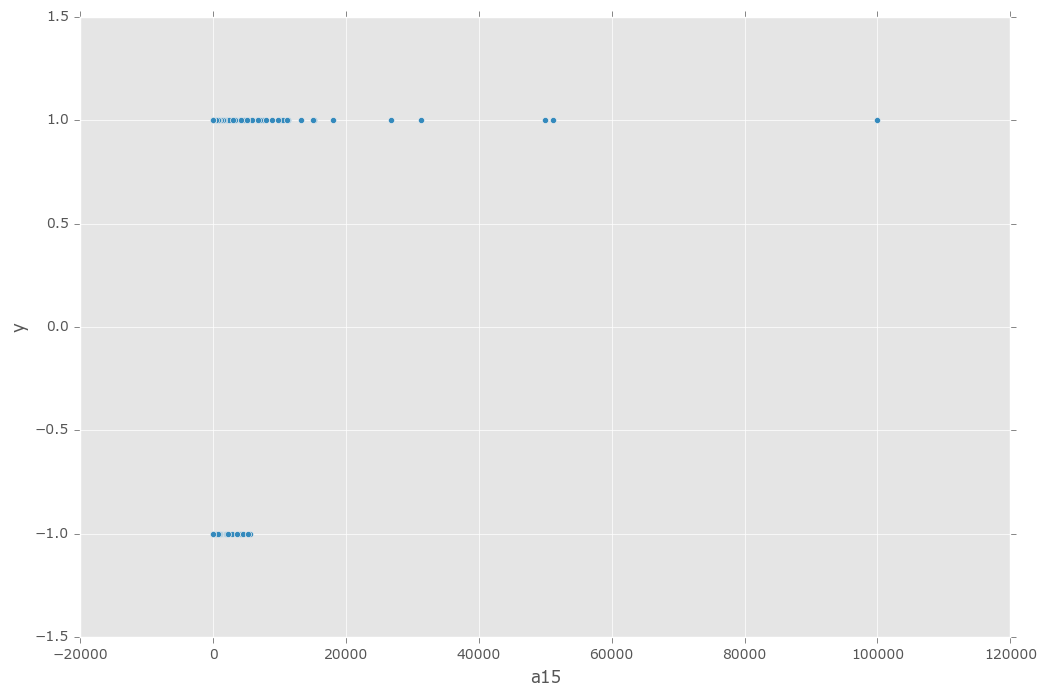

In [15]:
df.plot(x='a15', y='y', kind='scatter')

Почему бы не обучить по этим данным регрессию, предстказывающую значение $y$? Да потому что это ~~бред~~ не очень корректно!

## Немного теории

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Svm_separating_hyperplanes_%28SVG%29.svg/512px-Svm_separating_hyperplanes_%28SVG%29.svg.png'>

Нам надо найти уравнение прямой (гиперплоскости), которая бы могла разделить два класса ($H_2$ и $H_3$ подходят). В данном случае, уравнение прямой задаётся как: $$g(x) = w_0 + w_1x_1 + w_2x_2 = \langle w, x \rangle =  w^\top x$$

* Если $g(x^*) > 0$, то $y^* = \text{'черный'}$
* Если $g(x^*) < 0$, то $y^* = \text{'белый'}$
* Если $g(x^*) = 0$, то мы находимся на линии
* т.е. решающее правило: $y^* = sign(g(x^*))$

Некоторые геометрические особенности
* $\frac{w_0}{||w||}$ - расстояние от начала координат то прямой
* $\frac{|g(x)|}{||w||}$ - степень "уверенности" в классификациий
* Величину $M = y\langle w, x \rangle = y \cdot g(x)$ называют **отступом**(margin)

Если для какого-то объекта $M \geq 0$, то его классификация выполнена успешно.

Отлично! Значит нам надо просто минимизировать ошибки классификации для всех объектов:

$$L(w) = \sum_i [y^{(i)} \langle w, x^{(i)} \rangle < 0] \rightarrow \min_w$$
Проблема в том, что это будет комбинаторная оптимизация. Существуют различные аппроксимации этой функции ошибок:

<img src='http://jaquesgrobler.github.io/Online-Scikit-Learn-stat-tut/_images/plot_sgd_loss_functions_11.png'>

### Знакомьтесь - Линейная регрессия!

Перед тем как мы начнем, рассмотрим функцию $$\sigma(z) = \frac{1}{1 + exp{(-z)}},$$она называется **сигмойда**. Постройте данную фукнцию.

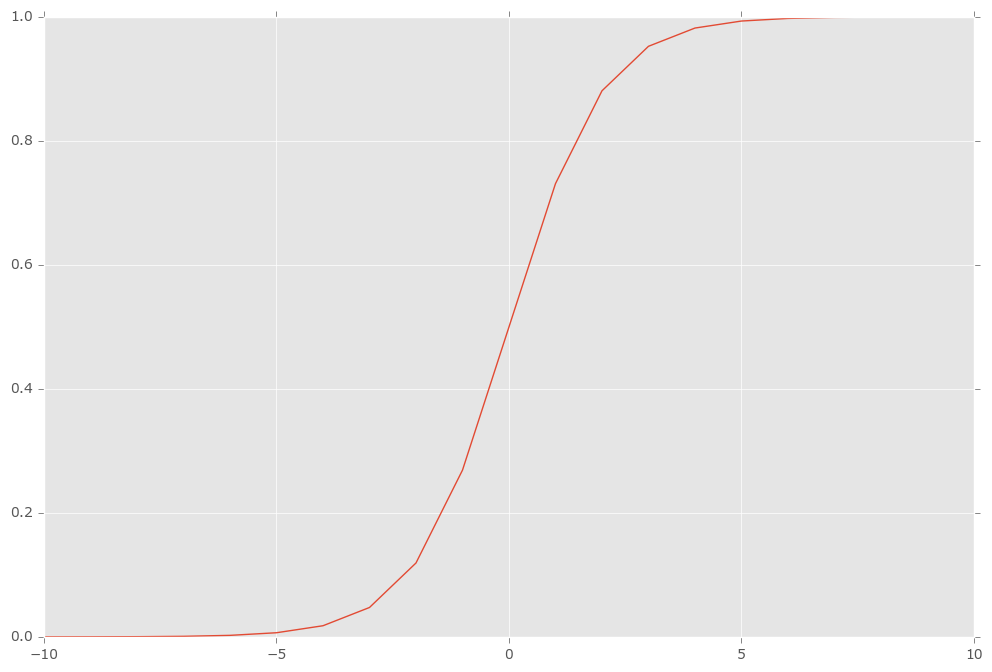

In [4]:
# Your code here
def sigmoid(z):
    return 1./(1+np.exp(-z))

z = np.arange(-10, 10)
s = sigmoid(z)

plt.plot(z, s)

Можно несколькими способами представить линейную регрессию. Один из самых простых - вот какой.

Рассмотрим принадлежность к классу $y=\pm1$ некого объекта $x$: $p(y=\pm1 | x,w)$ и выразим её через **сигмойду** от **отступа**:
$$p(y=\pm1|x,w) = \sigma(y \langle w, x \rangle) $$

А ошибка, которую мы будем минимизировать - логарифмическая:

$$L(w) = -\sum_i \log(\sigma(y^{(i)} \langle w, x^{(i)} \rangle)) \rightarrow \min_w$$

**История с регуляризацией, мультиколлинеарностью и шкалированием признаков здесь полностью повторяется!**

### Пример

Сгенерируем выборку и опробуем логистическую регрессию

In [5]:
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) + [2, 2],
          np.random.randn(20, 2) + [-2, -2]]
y = [-1] * 20 + [1] * 20

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[:, 0],
           X[:, 1],
           c=y,
           cmap=plt.cm.Paired)

In [16]:
from sklearn.linear_model import LogisticRegression

Обучите логистическую регрессию на этих данных и нарисуйте разделяющую гиперплоскость

In [17]:
## Your Code Here

### Как сделать нелинейную границу?

Рассмотрим набор данных, который в простонародье называют "Бублик".

In [18]:
from sklearn.datasets import make_circles

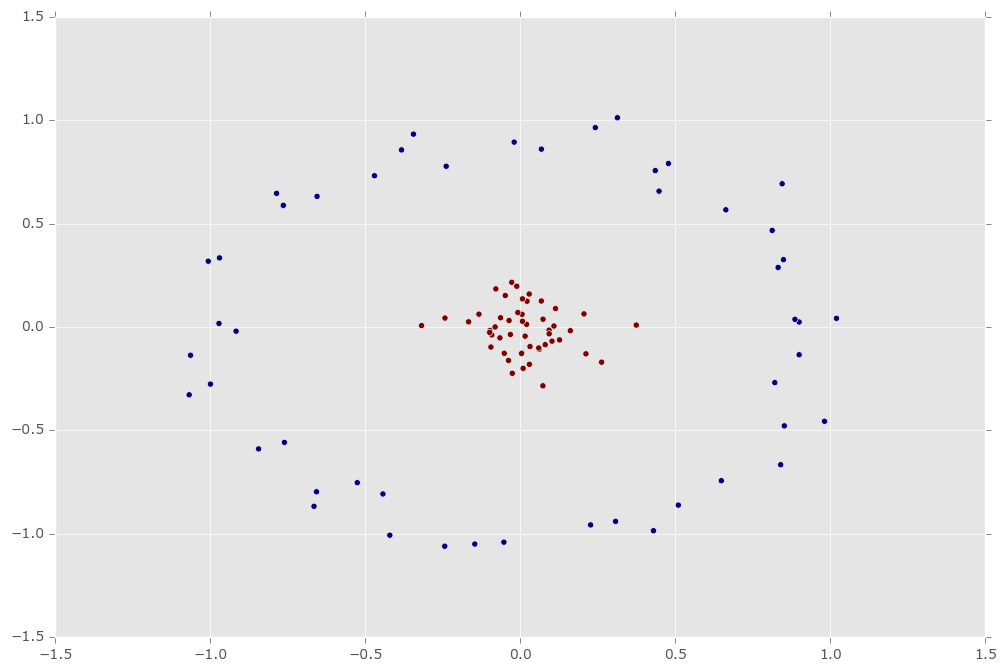

In [19]:
X, y = make_circles(n_samples=100, shuffle=True, noise = 0.1, factor=0.1)
X = X

plt.scatter(X[:, 0],
            X[:, 1],
            c=y)

Очевидно, что классы нельзя разделить линией. Но можно сделать это окружностью! </br>
Т.е. разделяющся линия теперь будет задаваться не уравнением прямой $g(x) = w_0 + w_1x_1 + w_2x_2$, а уравнением окружности $c(x) = (x_1 - a)^2 + (x_2 - b)^2 - R^2$. 

Выполните преобразование матрицы X, чтобы в ней были столбцы для $x_1$, $x^2_1$, $x_2$, $x^2_2$ и обучите логистическую регрессию

In [20]:
# Your code here

## Задача на "реальных" данных

### Предобработка данных

Вновь [данные](https://www.dropbox.com/s/jeijgsga8w55c8w/crx.data?dl=0) по кредитованию.

Столбец с классом называется `y`.<br/> Значение $1$ соответствует классу клиентов банка, которым выдали кредит и они его успешно вернули.<br/> Значение $-1$ соответствует клиентам, невыполнившим свои кредитные обязанности. 

В банке хотят уметь определять по признакам `a1-a15`, сможет ли новый клиент вернуть кредит или нет? То есть нам надо обучить классификатор! *Обычно, в банках используют скор-карты, но процесс их построения тесно связан с логистической регрессией*

Загрузите данные и преобразуйте признаки `a1`, `a9`, `a10` и `a12` из строковых в числовые. В них только 2 возможных значения. Для этого можно использовать функцию DataFrame.replace() в `pandas` или самое обычное присваивание на соответствующих строках.

В признаках `a6`, `a7` присутствуют "редкие" значение. Найдите их с помощью фунцкии `.value_counts()`  и объедините, присвоив им одно и то же значение, например `'Other'`.

Выделите бинарные признаки `a1`, `a9`, `a10` и `a12` в матрицу `X_binary`

Преобразуйте категориальные признаки `a5`, `a6`, `a7`, `a13` с помощью `DictVectorizer`. Вы должны получить матрицу `X_cat`.

Нормализуйте количественные признаки `a2`, `a3`, `a8`, `a11`, `a14` и `a15` с помощью `StandartScaler` или вручную. Вы должны получить матрицу `X_real`.

Матрица `X_cat` будет sparse-матрицой (разреженной). Преобразуте её в полную матрицу с помощью команд `X_cat = X_cat.toarray()` или `X_cat = X_cat.todence()`

Используйте функцию np.concatinate(..) или np.c[..] чтобы сцепить матрицы `X_binary`, `X_cat` и `X_real`

В результате вы должны получить матрицу с преобразованными призанками `X` и вектор ответов `y`

### Исследование влияния регуляризации

В случае с логистичесткой регресии, сложность модели выражается в значениях весов $w_j$ при признаках. Больший вес означает большее влияние признака на результат. В таком случае, давайте добавил штрафное слагаемое в функцию оптимизации для логистической регресии. Самый распространенные из них это:

* Ridge regression
$$L(w) = - \left(\sum_i \log(\sigma(y^{(i)} \langle w, x^{(i)} \rangle)) + \frac{1}{C}\sum_j w_j^2\right) \rightarrow \min_w$$

* Lasso regression
$$L(w) = -\left(\sum_i \log(\sigma(y^{(i)} \langle w, x^{(i)} \rangle) + \frac{1}{C}\sum_j |w_j|\right) \rightarrow \min_w$$

$C$ - называется гиперпараметром регуляризации и он задается вручную. Выбирается он с помощью кросс-валидации. Чем больше $С$ - тем меньше влияние регуляризации.


Разделите ваши даннные на обучающую и контрольную выборку в пропорции 70/30 соответственно.



Lasso regression называется так, потому что она осуществляет "отлов" признаков - т.е. незначимые признаки будут иметь нулевые веса в модели, в то время как в Ridge regression - веса будут постепенно падать у всех признаков.

<img src='http://webdancer.is-programmer.com/user_files/webdancer/Image/lasso.png'>

Давайте сравним работу регуляризаторов. 

1. Разбейте данные на обучающую и валидационную выборки в пропорции 70\30.
1. Для $C$ из набора np.logspace(-3, 3, 10) обучите LogisctigRegression c Lasso регуляризацией (`penalty='l1'`). На каждой итерации оцените качество (ROC-AUC) на контрольной выборке и запомните полученные коэффициенты модели
1. На одном графике выведите значение качества в зависимости от параметра `C` 
1. На другом графике для каждого признака выведите значение коэффициента в модели в зависимости от параметра `C`
1. Проделайте тоже самое для Ridge регуляризации (`penalty='l2'`)